# Sales Forecast and analysis

## Quod Financial Technical Test

> Done by **Tristan PERROT**


## Import libraries


In [39]:
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import os
import plotly.io as pio
pio.renderers.default = "vscode"

## Import Data

In [28]:
DATA_DIR = '..' + os.sep + 'data'

transactions_1 = pd.read_csv(DATA_DIR + os.sep + 'transactions_1.csv', index_col=0, parse_dates=['date'])
transactions_2 = pd.read_csv(DATA_DIR + os.sep + 'transactions_2.csv', index_col=0, parse_dates=['date'])

In [29]:
transactions_1

,customer_id,product_id,date
0,8649525,Opel,2017-01-31 09:31:08.873000+00:00
1,8649525,Volkswagen,2017-02-03 16:59:16.610000+00:00
2,8649525,Volkswagen,2017-02-05 19:47:55.353000+00:00
3,8649525,Volkswagen,2017-02-05 19:48:14.633000+00:00
4,8649525,Volkswagen,2017-02-06 09:59:49.053000+00:00
...,...,...,...
499995,8822663,Fiat,2019-12-17 10:15:10.907000+00:00
499996,8822663,Renault,2017-09-26 08:00:46.090000+00:00
499997,8822663,Renault,2017-09-26 08:17:36.350000+00:00
499998,8822663,Renault,2017-09-26 09:05:09.700000+00:00


In [30]:
transactions_2

,customer_id,product_id,date
500000,8822663,Abarth,2018-06-28 09:19:11.130000+00:00
500001,8822663,Peugeot,2019-07-17 08:06:29.500000+00:00
500002,8822663,Nissan,2017-06-22 07:29:22.440000+00:00
500003,8822663,Nissan,2017-06-22 07:50:10.863000+00:00
500004,8822663,Nissan,2017-06-22 08:40:35.923000+00:00
...,...,...,...
975950,1111821,Renault,2019-05-17 10:06:43.037000+00:00
975951,4232782,Renault,2017-10-27 17:49:54.483000+00:00
975952,4746355,Seat,2019-01-09 16:31:08.133000+00:00
975953,4743766,Opel,2017-03-29 16:25:05.907000+00:00


In [34]:
transactions_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 0 to 499999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   customer_id  500000 non-null  int64              
 1   product_id   500000 non-null  object             
 2   date         500000 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 15.3+ MB


In [45]:
all_transactions = pd.concat([transactions_1, transactions_2])

## Data Analysis

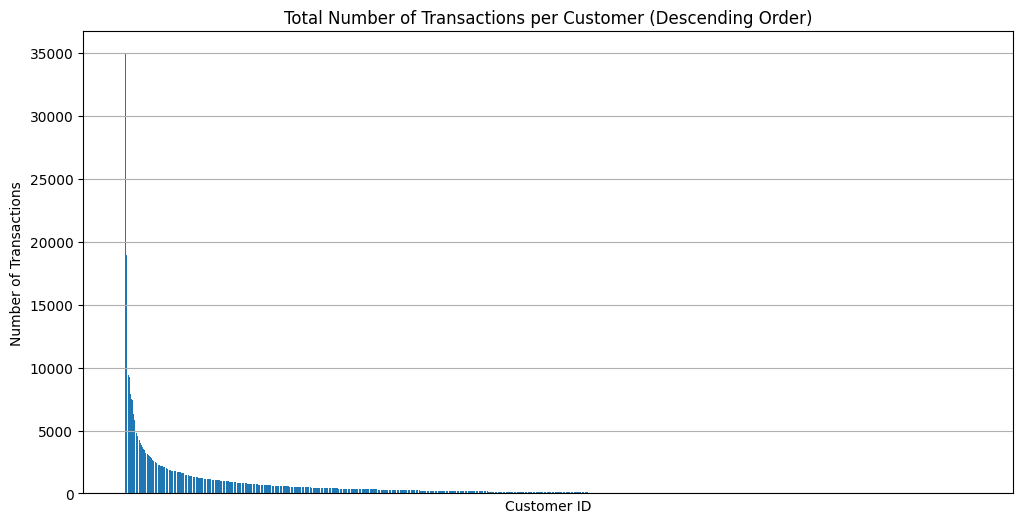

In [51]:
# Combine transactions and count the number per customer
transactions_per_customer = pd.concat([transactions_1, transactions_2]).groupby('customer_id').size()

# Sort in descending order
transactions_per_customer = transactions_per_customer.sort_values(ascending=False)

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(transactions_per_customer.index.astype(str), transactions_per_customer.values)

# Labels and title
plt.xlabel("Customer ID")  # Remove x-axis label text
plt.ylabel("Number of Transactions")
plt.title("Total Number of Transactions per Customer (Descending Order)")
plt.grid(axis='y')

# Remove x-axis ticks and labels for readability
plt.xticks([], []) 

# Show the plot
plt.show()

In [52]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px

# Initialize Dash app
app = dash.Dash(__name__)

# Layout
app.layout = html.Div([
    dcc.Dropdown(
        id='product-dropdown',
        options=[{'label': p, 'value': p} for p in all_transactions['product_id'].unique()],
        value=all_transactions['product_id'].unique()[0],
        clearable=False
    ),
    dcc.Graph(id='product-transaction-plot')
])

# Callback to update the plot
@app.callback(
    Output('product-transaction-plot', 'figure'),
    Input('product-dropdown', 'value')
)
def update_graph(product_id):
    # Filter transactions for the selected product
    transactions_2018 = all_transactions[
        (all_transactions['date'].dt.year == 2018) & (all_transactions['product_id'] == product_id)
    ]

    # Group by month
    transactions_2018_per_month = transactions_2018.groupby(transactions_2018['date'].dt.month).size().reset_index()
    transactions_2018_per_month.columns = ['Month', 'Number of Transactions']

    # Map month numbers to names
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    transactions_2018_per_month['Month'] = transactions_2018_per_month['Month'].apply(lambda x: month_names[x-1])

    # Create the figure
    fig = px.bar(
        transactions_2018_per_month,
        x="Month",
        y="Number of Transactions",
        title=f"Transaction Frequency per Month for {product_id} in 2018",
        labels={"Month": "Month", "Number of Transactions": "Transaction Count"},
        text="Number of Transactions"
    )
    
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

## Prediction model